### Import Packages

In [1]:
! nvidia-smi

Fri May  2 18:42:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:25:00.0 Off |                    0 |
| N/A   28C    P0             33W /  250W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, f1_score

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, MultiHeadAttention, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


### Data Preprocessing

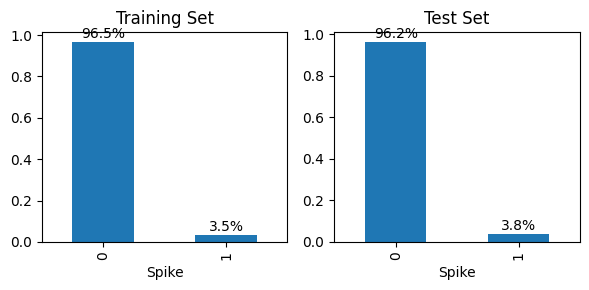

In [3]:
spike = 4
wind_cols = ['uSq','e_uSq','n_uSq','Z2','Z3','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')
df1['Spike'] = (df1['H'] > spike).astype(int)

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)

# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]

# Plot distributions of spikes and non-spikes
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
train_counts = df_train['Spike'].value_counts(normalize=True)
train_counts.plot(kind='bar')
plt.title('Training Set')
for i, v in enumerate(train_counts):
    plt.text(i, v+0.005, f'{v:.1%}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
test_counts = df_test['Spike'].value_counts(normalize=True)
test_counts.plot(kind='bar')
plt.title('Test Set')
for i, v in enumerate(test_counts):
    plt.text(i, v+0.005, f'{v:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Data Preparation: Train-Test-Validation Split

In [4]:
time_step = 6
features = ['Spike'] + scaled_wind_cols

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step+1), 1:])  # Past hours wind features
        y.append(data[i+time_step, 0])         # Current hour wave height
    return np.array(X), np.array(y)

# Training set: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2009-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# Validation set: [2008-11-01 00:00:00 ~ 2009-10-31 23:00:00]
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train1 = df_train[df_train.index < split1]
df_train2 = df_train[df_train.index > split3]
df_val = df_train[(df_train.index > split2) & (df_train.index < split3)]

X_train1, y_train1 = create_sequences(df_train1[features].values, time_step)
X_train2, y_train2 = create_sequences(df_train2[features].values, time_step)
X_train, y_train = np.concatenate((X_train1, X_train2), axis=0), np.concatenate((y_train1, y_train2), axis=0)
X_val, y_val = create_sequences(df_val[features].values, time_step)
X_test, y_test = create_sequences(df_test[features].values, time_step)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(61332, 7, 6)
(8754, 7, 6)
(8778, 7, 6)


### Model Selection and Implementation

In [ ]:
epochs = 100
batch_size = 64
model_file = 'model_cls.keras'

def create_model(X_train):
    # Input layer with shape: (batch_size, time_steps, features)
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    # LSTM layer
    units = 128
    lstm_layer = LSTM(units=64, activation='tanh', return_sequences=True)(input_layer)
    lstm_out = LSTM(units=units, activation='tanh', return_sequences=True)(lstm_layer)
    
    # Attention layer
    num_heads = 2
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=units//num_heads)(lstm_out, lstm_out)

    # Pooling layer
    pooled_out = GlobalAveragePooling1D()(attn_out)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(pooled_out)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=5.6e-4), loss='binary_crossentropy', metrics=['AUC'])
    
    return model

# Class weights computation
w_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
w_dict = {i:w_array[i] for i in range(len(w_array))}

# Train and save the model (architecture + weights)
model = create_model(X_train)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=w_dict, validation_data=(X_val, y_val), callbacks=[es])
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Hyperparameters Tuning

- **Time steps**: 6
- **Batch size**: 64
- **# of LSTM layers**: 1, 2, 3
- **# of LSTM units**: 32, 64, 128, 256
- **# of Attention heads**: 2, 4, 8
- **Activation**: 'tanh' (might work better for LSTM layers)
- **Learning rate**: logarithmic sampling of $10^{-4}$ ~ $10^{-2}$

In [5]:
%run hp_tuning_cls.py

Reloading Tuner from hp_tuning/model_cls/tuner0.json


In [6]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)
print()

# Best model
best_model = tuner.hypermodel.build(best_hp)
best_model.compile(optimizer=Adam(learning_rate=best_hp.values['learning_rate']), loss='binary_crossentropy', metrics=['AUC'])
print(best_model.summary())

{'layers': 2, 'units_0': 64, 'heads': 2, 'learning_rate': 0.0005595977770079655, 'units_1': 128, 'units_2': 128, 'tuner/epochs': 100, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}



I0000 00:00:1747067833.581600 2805430 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 64)     │     18,176 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 7, 128)    │     98,816 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ [(None, 7, 128),  │     66,048 │ lstm_1[0][0],     │
│ (MultiHeadAttentio… │ (None, 2, 7, 7)]  │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multihead_attn[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,169 (715.50 KB)

 Trainable params: 183,169 (715.50 KB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1747067839.427899 2806279 cuda_dnn.cc:529] Loaded cuDNN version 90300


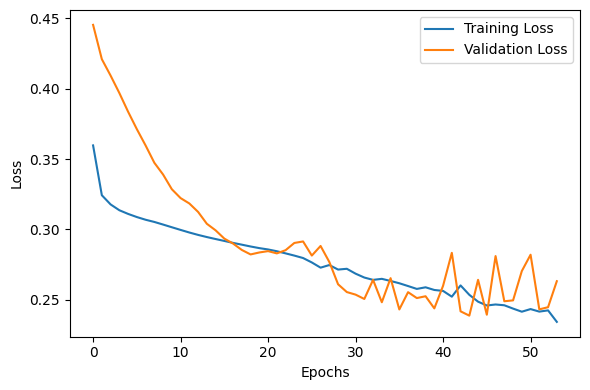

In [7]:
model_file = 'best_model_cls.keras'

# Train and save the model (architecture + weights)
history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=w_dict, validation_data=(X_val, y_val), callbacks=[es], verbose=0)
best_model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

In [8]:
threshold = 0.3

# Load the saved model
model = load_model(model_file)

# Training error
y_pred1 = model.predict(X_train, verbose=0)
y_pred1_raw = (y_pred1 >= threshold).astype(int)
y_true1 = pd.concat([df_train1['Spike'][time_step:], df_train2['Spike'][time_step:]], axis=0)

# Validation error
y_pred2 = model.predict(X_val, verbose=0)
y_pred2_raw = (y_pred2 >= threshold).astype(int)
y_true2 = df_val['Spike'][time_step:]

# Test error
y_pred3 = model.predict(X_test, verbose=0)
y_pred3_raw = (y_pred3 >= threshold).astype(int)
y_true3 = df_test['Spike'][time_step:]

print(f'Training Recall: {recall_score(y_true1, y_pred1_raw):.3f}')
print(f'Validation Recall: {recall_score(y_true2, y_pred2_raw):.3f}')
print(f'Test Recall: {recall_score(y_true3, y_pred3_raw):.3f}')
print()
print(f'Training F1: {f1_score(y_true1, y_pred1_raw):.3f}')
print(f'Validation F1: {f1_score(y_true2, y_pred2_raw):.3f}')
print(f'Test F1: {f1_score(y_true3, y_pred3_raw):.3f}')

Training Recall: 0.941
Validation Recall: 0.940
Test Recall: 0.979

Training F1: 0.305
Validation F1: 0.264
Test F1: 0.315


### Model Output

In [9]:
# Create sequences for the full dataset
X, _ = create_sequences(df1[features].values, time_step)

# Add predicted spikes
df1['Spike_prob'] = 0.0
df1.loc[df1.index[time_step:], 'Spike_prob'] = model.predict(X, verbose=0).flatten()
df1['Spike_pred'] = df1['Spike_prob'].apply(lambda x: 0.0 if x < threshold else 1.0)
df1.to_csv('Data_2004_2013.csv')

df1.head(10)

,H,uSq,e_uSq,n_uSq,Z2,Z3,Z4,scaled_H,scaled_uSq,scaled_e_uSq,scaled_n_uSq,scaled_Z2,scaled_Z3,scaled_Z4,H_pred0,Spike,Spike_prob,Spike_pred
TimeStamp_1,,,,,,,,,,,,,,,,,,
2004-11-01 00:00:00,3.249133,19.225945,18.733185,-4.324897,556.247086,16093.4,465615.964363,0.319463,0.042443,0.717843,0.427481,0.101141,0.042553,0.021635,0.000000,0,0.000000,0.0
2004-11-01 01:00:00,3.249133,47.299731,-43.539632,18.481477,872.475497,16093.4,296853.635864,0.319463,0.111609,0.612923,0.482862,0.181946,0.042553,0.012009,0.000000,0,0.000000,0.0
2004-11-01 02:00:00,1.960359,43.096993,-23.472305,-36.144180,832.812792,16093.4,310991.288972,0.192748,0.101255,0.646733,0.350213,0.171811,0.042553,0.012816,0.000000,0,0.000000,0.0
2004-11-01 03:00:00,2.001249,28.241040,-25.162951,-12.821164,674.161969,16093.4,384177.000917,0.196768,0.064654,0.643885,0.406849,0.131272,0.042553,0.016990,0.000000,0,0.000000,0.0
2004-11-01 04:00:00,3.254957,35.278017,-19.213785,-29.586634,753.487381,16093.4,343731.733585,0.320036,0.081991,0.653908,0.366137,0.151541,0.042553,0.014683,0.000000,0,0.000000,0.0
2004-11-01 05:00:00,3.298333,33.337921,-13.026164,-30.687718,732.475598,16093.4,353592.016416,0.324301,0.077211,0.664333,0.363463,0.146172,0.042553,0.015245,0.000000,0,0.000000,0.0
2004-11-01 06:00:00,0.298153,67.513173,56.621311,-36.770309,1042.361020,16093.4,248471.996288,0.029315,0.161410,0.781679,0.348693,0.225356,0.042553,0.009250,0.168065,0,0.204404,0.0
2004-11-01 07:00:00,0.329992,43.711596,31.968638,-29.811237,838.730115,16093.4,308797.214744,0.032446,0.102769,0.740143,0.365591,0.173323,0.042553,0.012690,0.184581,0,0.331286,1.0
2004-11-01 08:00:00,0.307853,55.203975,40.373631,-37.649020,942.560154,16093.4,274780.895794,0.030269,0.131084,0.754304,0.346559,0.199855,0.042553,0.010750,0.174609,0,0.411070,1.0
